# Guide RNA assignment

Assigning relevant guides to each cell is essential for quality control in perturbation assays, ensuring that the observed cellular responses are accurately linked to the intended genetic modifications. 
This step is critical for validating the experimental design and interpreting results reliably, thereby maintaining the integrity and reproducibility of the research.
Here, we demonstrate how to visualize guide RNAs in a perturbation assay and how to assign relevant guides to each cell.

## Setup

In [2]:
import pertpy as pt
import scanpy as sc
import scipy

Installed version 0.4.0 of pertpy is newer than the latest release 0.3.0! You are running a nightly version and 
features may break!

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

## Dataset

All guides should be available as a separate AnnData object containing counts of each guide for each cell.
The `var_names` of the AnnData correspond to the ID of these guides. In this example the 'gdo' modality contains guide RNA expression values.

Let's load the Papalexi dataset. We will try to reproduce the guide assignment of the dataset.

In [3]:
mdata = pt.data.papalexi_2021()
# seems like an error in the original data
mdata.mod["gdo"].X = scipy.sparse.csr_matrix(mdata.mod["gdo"].X.A - 1)
gdo = mdata.mod["gdo"]
gdo

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'

Then we save the original count values and transform the data using log transformation.

In [4]:
gdo.layers["counts"] = gdo.X.copy()
sc.pp.log1p(gdo)
gdo

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'
    uns: 'log1p'
    layers: 'counts'

We can visualize the expression of guides per cells to get more insight. By passing the argument `key_to_save_order` to the function, the order of cells in the plot will be saved in obs of the data.

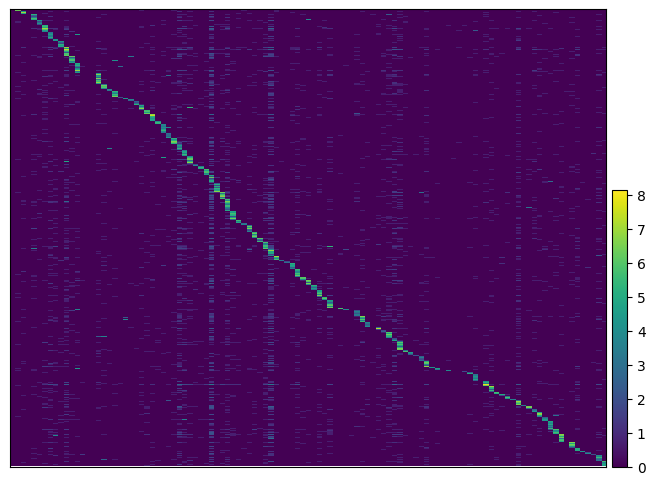

In [5]:
pt.pl.guide.heatmap(gdo, key_to_save_order="plot_order")

In [6]:
gdo

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'plot_order'
    var: 'name'
    uns: 'log1p'
    layers: 'counts'

## Simple thresholding

Then we assign guides based on a simple thresholding mechanism. Here we consider a guide only if there are at least 5 counts. Please note which layer you pass to the function.

In [7]:
ga = pt.pp.GuideAssignment()
ga.assign_by_threshold(gdo, assignment_threshold=5, layer="counts")
gdo

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'plot_order'
    var: 'name'
    uns: 'log1p'
    layers: 'counts', 'assigned_guides'

Then we again plot the heatmap of the assigned guides to see the effect of the assignment. 
We use the same ordering as in the previous plot to that we can compare the two plots.

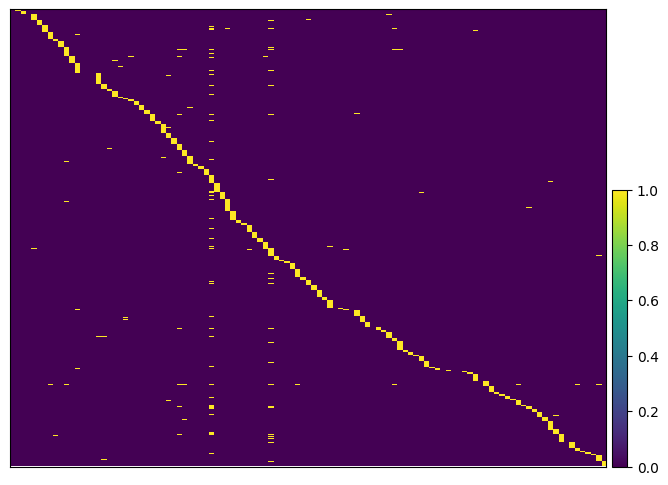

In [8]:
ga.plot_guide.heatmap(gdo, layer="assigned_guides", order_by="plot_order")

## Most frequent guide

We can also assign to the guide RNA with the highest detection:

In [9]:
ga = pt.pp.GuideAssignment()
ga.assign_to_max_guide(gdo, assignment_threshold=5, layer="counts")

As we see it completely maches the guide assignment in the mixscape pipeline:

In [10]:
sum(gdo.obs["assigned_guide"] != gdo.obs["guide_ID"])

0

## References

1. Papalexi, E., Mimitou, E.P., Butler, A.W. et al. Characterizing the molecular regulation of inhibitory immune checkpoints with multimodal single-cell screens. Nat Genet 53, 322–331 (2021). https://doi.org/10.1038/s41588-021-00778-2